## Bagging Exercises

### Introduction 
We will be using the customer churn data from the telecom industry for these exercises. The datafile is called `Orange_Telecom_Churn_Data.csv`. 

### Prerequisites 
Install `imblearn` and upgrade `sklearn` to 0.19.0

In [1]:
# In Anaconda prompt: 
# python -m pip install imblearn 
# python -m pip install --upgrade sklearn 

In [2]:
from __future__ import print_function 
import os 
data_path = ['data']

### Question 1
* Import the customer churn data, found in the file `Orange_Telecom_Churn_Data.csv`
* Remove any columns that are likely not to be used for prediction. 
* Encode data types as appropriate 

In [3]:
import pandas as pd 
import numpy as np 

filepath = os.sep.join(data_path + ['Orange_Telecom_Churn_Data.csv'])
data = pd.read_csv(filepath, sep = ',')

In [4]:
data.head().T

,0,1,2,3,4
state,KS,OH,NJ,OH,OK
account_length,128,107,137,84,75
area_code,415,415,415,408,415
phone_number,382-4657,371-7191,358-1921,375-9999,330-6626
intl_plan,no,no,no,yes,yes
voice_mail_plan,yes,yes,no,no,no
number_vmail_messages,25,26,0,0,0
total_day_minutes,265.1,161.6,243.4,299.4,166.7
total_day_calls,110,123,114,71,113
total_day_charge,45.07,27.47,41.38,50.9,28.34


The prediction should definitely not include phone number. And it is unlikely that area code or state would be desired, unless there is some reason to assume the model has a very specific geographic factor. 

In [5]:
data.drop(['state', 'phone_number', 'area_code'], axis = 1, inplace = True)

Examine the data types. Everything looks OK other than `int_plan` and `voice_mail_plan` need to be boolean encoded. 

In [6]:
data.dtypes

account_length                     int64
intl_plan                         object
voice_mail_plan                   object
number_vmail_messages              int64
total_day_minutes                float64
total_day_calls                    int64
total_day_charge                 float64
total_eve_minutes                float64
total_eve_calls                    int64
total_eve_charge                 float64
total_night_minutes              float64
total_night_calls                  int64
total_night_charge               float64
total_intl_minutes               float64
total_intl_calls                   int64
total_intl_charge                float64
number_customer_service_calls      int64
churned                             bool
dtype: object

In [7]:
for col in ['intl_plan', 'voice_mail_plan']: 
    data[col] = data[col].replace('yes', True).replace('no', False)
    

In [8]:
data[['intl_plan', 'voice_mail_plan']].dtypes

intl_plan          bool
voice_mail_plan    bool
dtype: object

### Question 2
* Examine distribution of the predicted variable (`churned`).
* Split the data into train and test sets. Decide if a stratified split should be used or not based on the distribution. 
* Examine the distribution of the predictor variable in the train and test data. 

In [9]:
data.churned.value_counts()

False    4293
True      707
Name: churned, dtype: int64

In [10]:
data.churned.value_counts(normalize = True)

False    0.8586
True     0.1414
Name: churned, dtype: float64

Data are skewed at 85% non-churned customers.  This will be important to remember when model building. 

Given the skew in the predictor variable, let's split the data iwth the `churned` values being stratified 

In [11]:
from sklearn.model_selection import StratifiedShuffleSplit 

feature_cols = [x for x in data.columns if x != 'churned']

# Split the data into two parts with 1500 points in the test data
# This is a generator 
strat_shuff_split = StratifiedShuffleSplit(n_splits = 1, 
                                           test_size = 1500, 
                                           random_state = 42)

# Get the index values from the generator 
train_idx, test_idx = next(strat_shuff_split.split(data[feature_cols], 
                                                   data['churned']))

In [12]:
# Create datasets 
X_train = data.loc[train_idx, feature_cols]
y_train = data.loc[train_idx, 'churned']

X_test = data.loc[test_idx, feature_cols]
y_test = data.loc[test_idx, 'churned']

In [13]:
y_train.value_counts(normalize = True) # y_train is Series, X_train is DataFrame

False    0.858571
True     0.141429
Name: churned, dtype: float64

In [14]:
y_test.value_counts(normalize = True)

False    0.858667
True     0.141333
Name: churned, dtype: float64

### Question 3
* Fit random forest models with a range of tree numbers and evaluate the out-of-bag error for each of these models. 
* Plot the resulting oob errors as a function of the number of trees. 

*Hint*: Since the only thing changing is the number of trees, the `warm_start` flag can be used so that the model just adds more trees to the existing model each time. Use the `set_params` method to update the number of trees. 

In [15]:
# Suppress warnings about too few trees from the early models 

import warnings 
warnings.filterwarnings('ignore', category = UserWarning)
warnings.filterwarnings('ignore', category = RuntimeWarning)

In [16]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the random forest estimator 
# Note that the number of trees is not setup here 
RF = RandomForestClassifier(oob_score = True, 
                            random_state = 42, 
                            warm_start = True, 
                            n_jobs = -1)

oob_list = list()


In [17]:
# Iterate through all of the possibilities for number of trees
for n_trees in [15, 20, 30, 40, 50, 100, 150, 200, 300, 400]:
    
    # Use this to set the number of trees 
    RF.set_params(n_estimators = n_trees)
    
    # Fit the model 
    RF.fit(X_train, y_train)
    
    # Get the oob error 
    oob_error = 1 - RF.oob_score_
    
    # Store it 
    oob_list.append(pd.Series({'n_trees': n_trees, 
                               'oob': oob_error}))
    
rf_oob_df = pd.concat(oob_list, axis = 1). T.set_index('n_trees')

rf_oob_df 

,oob
n_trees,
15.0,0.059714
20.0,0.053429
30.0,0.049714
40.0,0.047429
50.0,0.049143
100.0,0.045143
150.0,0.045143
200.0,0.044857
300.0,0.044286


In [18]:
import matplotlib.pyplot as plt 
import seaborn as sns 

%matplotlib inline 

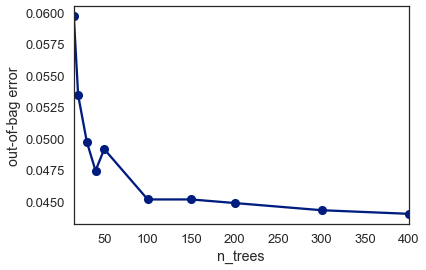

In [19]:
sns.set_context('talk')
sns.set_palette('dark')
sns.set_style('white')

ax = rf_oob_df.plot(legend = False, marker = 'o')
ax.set(ylabel = 'out-of-bag error'); 

Error stabilizes around 100-150 trees 

### Question 4 
* Repeat question 3 using extra randomized trees (`ExraTreesClassifier`).  Note that the `bootstrap` parameter will have to be set to `True` for this model. 
* Compare the out-of-bag errors for the two different types of models. 

In [20]:
from sklearn.ensemble import ExtraTreesClassifier

# Initialize the random forest estimator 
# Note that the number of trees is not set up here 
EF = ExtraTreesClassifier(oob_score = True, 
                          random_state = 42, 
                          warm_start = True, 
                          bootstrap = True, 
                          n_jobs = -1)


oob_list = list() 

# Iterate through all of the possibilities for number of trees 
for n_trees in [15, 20, 30, 40, 50, 100, 150, 200, 300, 400]: 
    
    # Use this to set the number of trees
    EF.set_params(n_estimators = n_trees)
    EF.fit(X_train, y_train)
    
    # oob error 
    oob_error = 1 - EF.oob_score_
    oob_list.append(pd.Series({'n_trees': n_trees, 
                              'oob': oob_error}))
    
et_oob_df = pd.concat(oob_list, axis = 1).T.set_index('n_trees')

et_oob_df

,oob
n_trees,
15.0,0.080857
20.0,0.072000
30.0,0.069429
40.0,0.064286
50.0,0.067429
100.0,0.062857
150.0,0.061143
200.0,0.062571
300.0,0.060286


In [21]:
# Combine RandomForest and ExtraTreeClassifiers into one dataframe 
oob_df = pd.concat([rf_oob_df.rename(columns = {'oob': 'RandomForest'}), 
                    et_oob_df.rename(columns = {'oob': 'ExtraTrees'})], 
                    axis = 1)

oob_df 

,RandomForest,ExtraTrees
n_trees,,
15.0,0.059714,0.080857
20.0,0.053429,0.072000
30.0,0.049714,0.069429
40.0,0.047429,0.064286
50.0,0.049143,0.067429
100.0,0.045143,0.062857
150.0,0.045143,0.061143
200.0,0.044857,0.062571
300.0,0.044286,0.060286


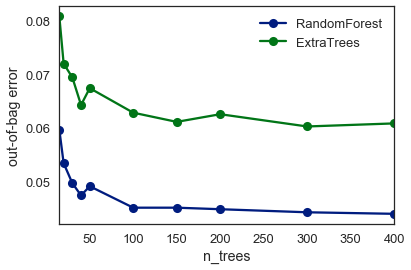

In [22]:
sns.set_context('talk')
sns.set_palette('dark')
sns.set_style('white') 

ax = oob_df.plot(marker = 'o') 
ax.set(ylabel = 'out-of-bag error'); 


### Question 5 
* Select one of the models that performs well and calculate error metrics and a confusion matrix on the test data set. 
* Given the distribution of the predicted class, which metric is most important? Which could be deceiving? 

In [23]:
# Random Forest with 100 estimators 
model = RF.set_params(n_estimators = 100)

y_pred = model.predict(X_test)

In [24]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score 
from sklearn.metrics import f1_score, roc_auc_score

cr = classification_report(y_test, y_pred)
print(cr) 

score_df = pd.DataFrame({'accuracy': accuracy_score(y_test, y_pred),
                         'precision': precision_score(y_test, y_pred), 
                         'recall': recall_score(y_test, y_pred), 
                         'f1': f1_score(y_test, y_pred), 
                         'auc': roc_auc_score(y_test, y_pred)}, 
                        index = pd.Index([0]))

print(score_df) # these scores are only for the churned cases

             precision    recall  f1-score   support

      False       0.96      0.99      0.98      1288
       True       0.95      0.76      0.85       212

avg / total       0.96      0.96      0.96      1500

   accuracy       auc        f1  precision    recall
0  0.960667  0.878582  0.845953   0.947368  0.764151


Unsuprisingly, recall(sensitivity, % of positives that are predicted correctly) is rather poor for the customers who churned (True) class since they are quite small. We are doing better than random guessing, though, as the accuracy is 0.932 [aside: I calculated 0.961] (vs 0.85 for random guessing).  

### Question 6 
* Print or visualize the ocnfusion matrix. 
* Plot the ROC-AUC and precision-recall curves. 
* Plot the feature importances. 

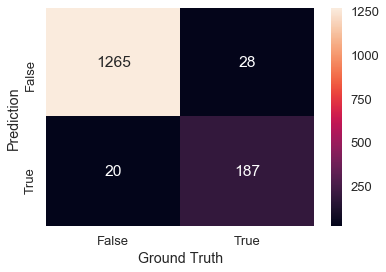

In [81]:
from sklearn.metrics import roc_curve, precision_recall_curve, confusion_matrix 

sns.set_context('talk')
cm = confusion_matrix(y_test, y_pred) 
ax = sns.heatmap(cm, annot = True, fmt = 'd' ) 

labels = ['False', 'True']
ax.set_xticklabels(labels); 
ax.set_yticklabels(labels); # original was wrong: ax.set_yticklabels(labels[::-1])
ax.set_ylabel('Prediction'); 
ax.set_xlabel('Ground Truth');

In [26]:
# ROC-AUC and precision-recall curves 
sns.set_context('talk')

# Get the probabilities for each of the two categories 
y_prob = model.predict_proba(X_test)


Good explanation of ROC and AUC curves [https://www.youtube.com/watch?v=OAl6eAyP-yo]

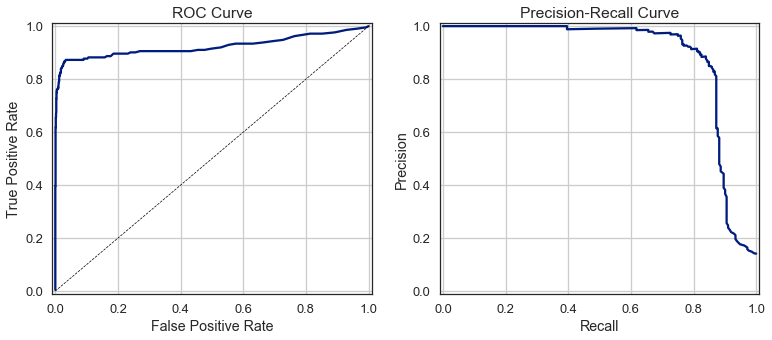

In [27]:
# Plot the ROC-AUC curve 
fig, axList = plt.subplots(ncols = 2) 
fig.set_size_inches(11,5)
ax = axList[0]

fpr, tpr, thresholds = roc_curve(y_test, y_prob[:,1])
ax.plot(fpr, tpr) 

# Random guess line 
ax.plot([0,1], [0,1], 
        ls = '--', 
        color = 'black', 
        lw = 0.7)

ax.set(xlabel = 'False Positive Rate', ylabel = 'True Positive Rate', 
       xlim = [-0.01, 1.01], ylim = [-0.01, 1.01], 
       title = 'ROC Curve')

ax.grid(True)


# Plot the precision-recall curve 
ax = axList[1]

precision, recall, _ = precision_recall_curve(y_test, y_prob[:,1])
ax.plot(recall, precision)
ax.set(xlabel = 'Recall', ylabel = 'Precision', 
       xlim = [-0.01, 1.01], ylim = [-0.01, 1.01], 
       title = 'Precision-Recall Curve')
ax.grid(True)

plt.tight_layout()

It is customary to draw a diagonal dotted line in ROC plots. This is to indicate completely random prediction. Deviation form this dotted line towards the upper left corner signifies the power of the model. 

In [28]:
feature_imp = pd.Series(model.feature_importances_, 
                        index = feature_cols).sort_values(ascending = False)

feature_imp

total_day_charge                 0.143981
total_day_minutes                0.141530
number_customer_service_calls    0.106282
intl_plan                        0.082460
total_eve_charge                 0.065254
total_eve_minutes                0.064955
total_intl_calls                 0.056976
total_intl_charge                0.043180
total_intl_minutes               0.042972
total_night_minutes              0.042285
total_night_charge               0.040849
account_length                   0.032114
total_night_calls                0.030182
number_vmail_messages            0.030158
total_day_calls                  0.028856
total_eve_calls                  0.025962
voice_mail_plan                  0.022001
dtype: float64

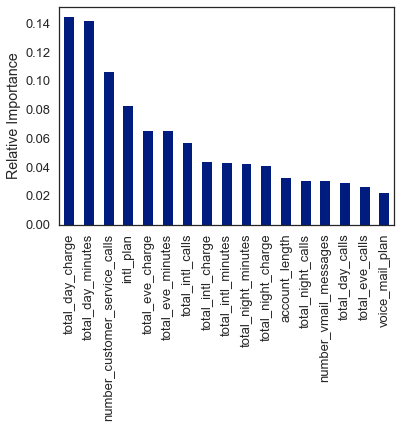

In [29]:
ax = feature_imp.plot(kind = 'bar')
ax.set(ylabel = 'Relative Importance'); 

The feature importances indicate that total daily cost is the biggest predictor of customer churn. 

#### Churn data has lot of class imbalance. 
To fix it, use different sampling techniques like SMOTE, RandomOverSampling. Refer to http://contrib.scikit-learn.org/imbalanced-learn/stable/api.html

After fixing class imbalance, check the metrics for different techniques. 

In [30]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import recall_score 
from imblearn.over_sampling import SMOTE 
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from imblearn import over_sampling as os_smote 
from imblearn import under_sampling as us_smote 
from imblearn import combine as cs_smote 

### Question 7
Create different objects using multiple smoting methods


Ex: `os_sm = os_smote.SMOTE(random_state = 45, ratio = 0.6)`

* Regenerate `X_train` and `y_train` using SMOTE object 

* Cross verify the value counts 

In [31]:
X = data[feature_cols]
y = data['churned']

In [32]:
os_sm = os_smote.SMOTE(random_state = 45, ratio = 0.6)
os_sm

SMOTE(k=None, k_neighbors=5, kind='regular', m=None, m_neighbors=10, n_jobs=1,
   out_step=0.5, random_state=45, ratio=0.6, svm_estimator=None)

In [33]:
# print(sorted(Counter(y_resampled).items()))
warnings.filterwarnings('ignore')
X_resample_osm, y_resample_osm = os_sm.fit_sample(X,y)

In [34]:
# train_test_split on original data 
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.3, 
                                                    random_state = 42) 

In [35]:
print(y_test.value_counts()) 
print(y_test.value_counts(True))
'Size of y_test: {0}'.format(y_test.shape[0])

False    1293
True      207
Name: churned, dtype: int64
False    0.862
True     0.138
Name: churned, dtype: float64


'Size of y_test: 1500'

In [36]:
# train_test_split on resampled data 
X_train_res_osm, X_test_res_osm, y_train_res_osm, y_test_res_osm = train_test_split(X_resample_osm, y_resample_osm, 
                                                                                    test_size = 0.3, 
                                                                                    random_state = 42)

In [37]:
y_test_res_osm = pd.Series(y_test_res_osm)

In [38]:
print(y_test_res_osm.value_counts())
print(y_test_res_osm.value_counts(True))
'Size of y_test_res_osm: {0}'.format(y_test_res_osm.shape[0])


False    1305
True      756
dtype: int64
False    0.633188
True     0.366812
dtype: float64


'Size of y_test_res_osm: 2061'

### Question 8 
* Fit random forest models with a range of tree numbers and evaluate the out-of-bag error for each of these models. 
* Plot the resulting oob errors as a function of the number of trees.

*Hint*: Since the only thing changing is the number of trees, the `warm_start` flag can be used so that the model just adds more trees to the existing model each time. Use the `set_params` method to update the number of trees. 

*Note*: Use re-sampled data

In [39]:
import matplotlib.pyplot as plt 
import seaborn as sns 
%matplotlib inline 

sns.set_context('talk') 
sns.set_palette('dark')
sns.set_style('white')

In [40]:
from sklearn.ensemble import RandomForestClassifier 

# Initialize random forest estimator 
RF = RandomForestClassifier(oob_score = True, 
                            random_state = 42, 
                            warm_start = True, 
                            n_jobs = -1)

oob_list_rf = list()

# Iterate through all possibilities for number of trees 
for n_trees in [15, 20, 30, 40, 50, 100, 150, 200, 300, 400]:
    
    # set number of trees
    RF.set_params(n_estimators = n_trees)
    
    # fit the model
    RF.fit(X_train_res_osm, y_train_res_osm)
    
    # get the oob error 
    oob_error = 1 - RF.oob_score_
    
    # store into list 
    oob_list_rf.append(pd.Series({'n_trees': n_trees, 
                               'oob': oob_error}))
    
rf_oob_df_res_osm = pd.concat(oob_list_rf, axis = 1).T.set_index('n_trees')

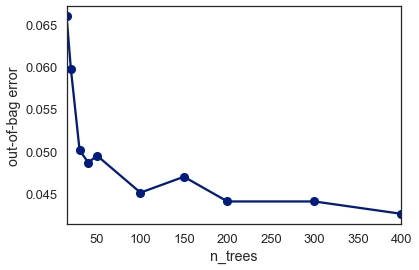

In [41]:
ax = rf_oob_df_res_osm.plot(legend = False, marker = 'o')
ax.set(ylabel = 'out-of-bag error'); 

### Question 9 
* Repeat question 3 using extra randomized trees (`ExtraTreesClassifier`). Note that the `bootstrap` parameter will have to be set to `True` for this model. 
* Compare the out-of-bag errors for the two different types of models. 

#### For different SMOTE models 

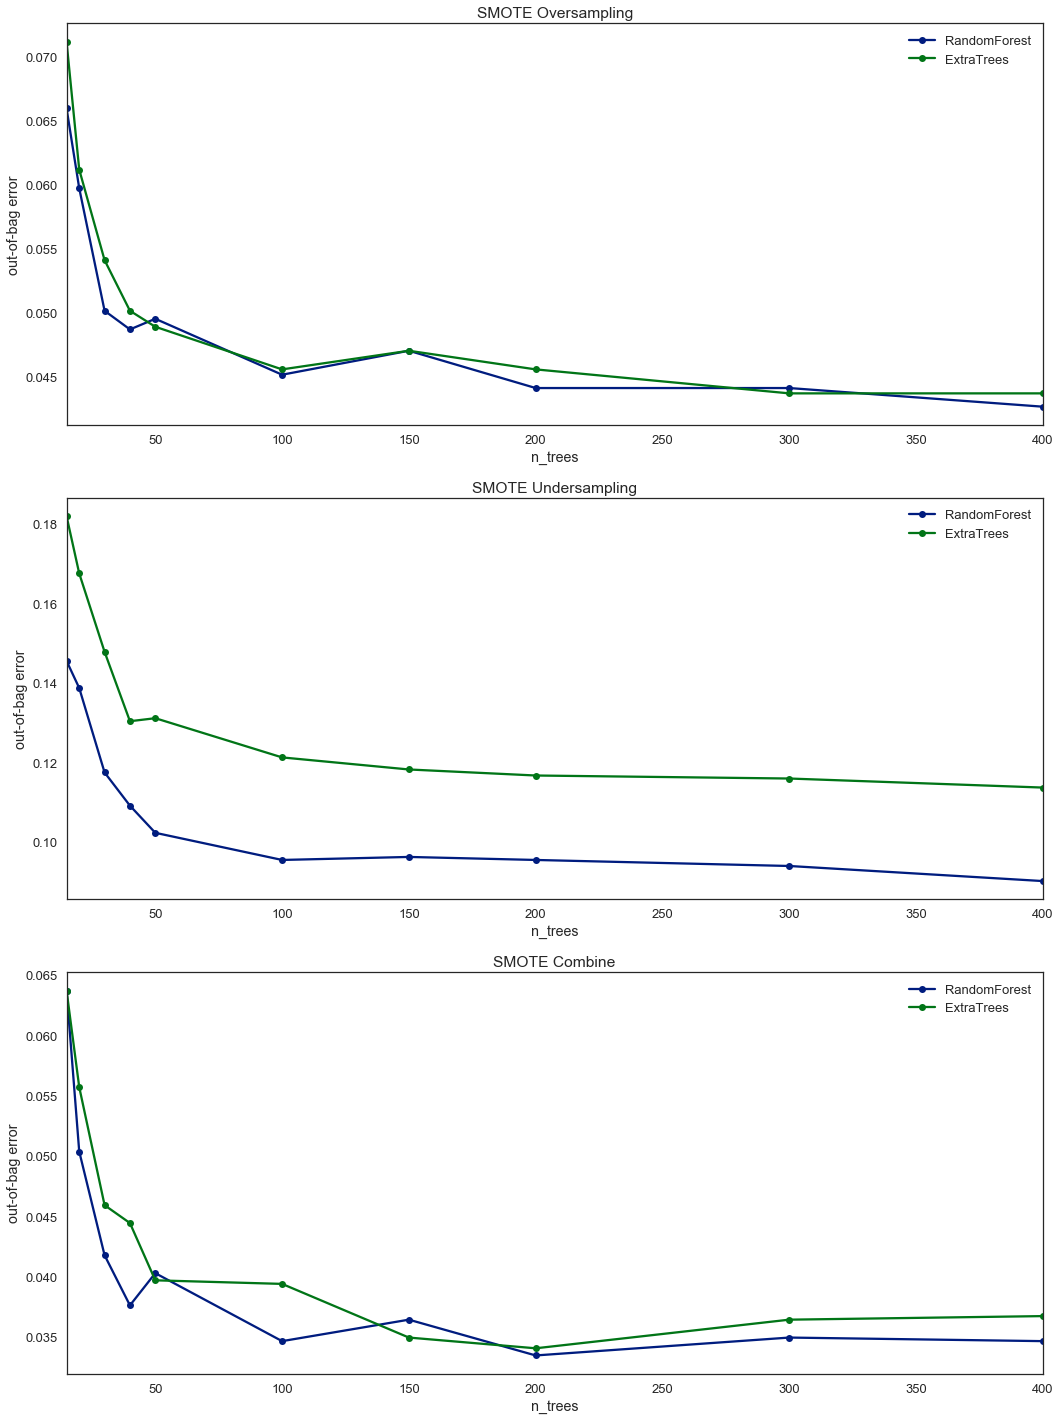

In [61]:
from sklearn.ensemble import ExtraTreesClassifier 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.base import clone

os_sm = os_smote.SMOTE(random_state = 45, ratio = 0.6)
us_sm = us_smote.RandomUnderSampler(random_state = 45, ratio = 0.6)
cs_sm = cs_smote.SMOTEENN(random_state = 45, ratio = 0.6)

SMOTE = [os_sm, us_sm, cs_sm]
label = ['Oversampling', 'Undersampling', 'Combine']

fig, axList = plt.subplots(nrows = 3, ncols = 1)
axList = axList.flatten()
fig.set_size_inches(15,20)

for sampler in enumerate(SMOTE): 
    
    # Initialize estimators
    RF = RandomForestClassifier(oob_score = True, 
                            random_state = 42, 
                            warm_start = True, 
                            n_jobs = -1)

    EF = ExtraTreesClassifier(oob_score = True, 
                          random_state = 42, 
                          warm_start = True, 
                          bootstrap = True, 
                          n_jobs = -1)
    
    # Fit SMOTE model
    X_resample, y_resample = sampler[1].fit_sample(X,y)
    
    # Split into train and test
    X_train_res, X_test_res, y_train_res, y_test_res = train_test_split(X_resample, y_resample, 
                                                                        test_size = 0.3, 
                                                                        random_state = 42)

    oob_list_rf = list()
    oob_list_et = list() 

    # Iterate through all possibilities for number of trees 
    for n_trees in [15, 20, 30, 40, 50, 100, 150, 200, 300, 400]:
    
        # Random Forest Estimator
        RF.set_params(n_estimators = n_trees)
        RF.fit(X_train_res, y_train_res)
        oob_error_rf = 1 - RF.oob_score_
        oob_list_rf.append(pd.Series({'n_trees': n_trees, 
                                      'oob': oob_error_rf}))
        
        # Extra Trees Classifier
        EF.set_params(n_estimators = n_trees)     
        EF.fit(X_train_res, y_train_res)     
        oob_error_et = 1 - EF.oob_score_    
        oob_list_et.append(pd.Series({'n_trees': n_trees, 
                                      'oob': oob_error_et}))
        
    # Out of bag error for RF and ET    
    rf_oob_df_res = pd.concat(oob_list_rf, axis = 1).T.set_index('n_trees')
    et_oob_df_res = pd.concat(oob_list_et, axis = 1).T.set_index('n_trees')

    # Combine into 1 dataframe
    oob_df_res = pd.concat([rf_oob_df_res.rename(columns = {'oob': 'RandomForest'}), 
                        et_oob_df_res.rename(columns = {'oob': 'ExtraTrees'})], 
                        axis = 1)
        
    # Plot RF vs ET 
    ax = axList[sampler[0]]
    oob_df_res.plot(marker = 'o', ms = 7.0, ax = ax)
    ax.set(ylabel = 'out-of-bag error'); 
    ax.set(title = 'SMOTE ' + str(label[sampler[0]]))
    plt.tight_layout()



The random forest model performs better than the extra randomized trees. 

### Question 10 
* Select one of the models that performs well and calculate error metrics and a confusion matrix on the test data set. 
* Given the distribution of the predicted class, which metric is most important? Which could be deceiving?

In [66]:
# Random Forest using combined under and oversampling with 200 estimators 
model = RF.set_params(n_estimators = 200)
y_pred_res = model.predict(X_test_res)


In [67]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score 
from sklearn.metrics import f1_score, roc_auc_score

cr = classification_report(y_test_res, y_pred_res)
print(cr) 

score_df = pd.DataFrame({'accuracy': accuracy_score(y_test_res, y_pred_res),
                         'precision': precision_score(y_test_res, y_pred_res), 
                         'recall': recall_score(y_test_res, y_pred_res), 
                         'f1': f1_score(y_test_res, y_pred_res), 
                         'auc': roc_auc_score(y_test_res, y_pred_res)}, 
                        index = pd.Index([0]))

print(score_df) # these scores are only for the churned cases

             precision    recall  f1-score   support

      False       0.96      0.99      0.98       823
       True       0.98      0.95      0.97       623

avg / total       0.97      0.97      0.97      1446

   accuracy       auc        f1  precision    recall
0  0.971646  0.969045  0.966531   0.983389  0.950241


In [74]:
print(pd.Series(y_test_res).value_counts())
print(pd.Series(y_test_res).value_counts(normalize = True))

False    823
True     623
dtype: int64
False    0.569156
True     0.430844
dtype: float64


Recall is significantly improved compared to the previous models without additional sampling.  This is because the distribution of the data is now more balanced with the additional sampling of the churned data (50/50 distribution of churned and unchurned).  Because of this, accuracy is likely an acceptable metric to use here. 

### Question 11 
* Print or visualize the confusion matrix. 
* Plot the ROC-AUC and precision-recall curves. 
* Plot the feature importances. 

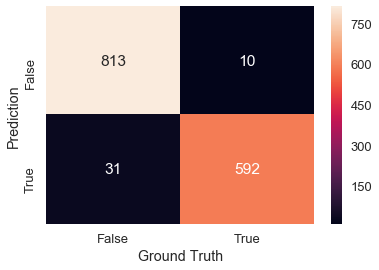

In [80]:
from sklearn.metrics import roc_curve, precision_recall_curve, confusion_matrix 

sns.set_context('talk') 
cm = confusion_matrix(y_test_res, y_pred_res)
ax = sns.heatmap(cm, annot = True, fmt = 'd')

labels = ['False', 'True']
ax.set_xticklabels(labels); 
ax.set_yticklabels(labels); 
ax.set_ylabel('Prediction'); 
ax.set_xlabel('Ground Truth'); 

In [82]:
# ROC-AUC and precision-recall curves 
sns.set_context('talk')

# Get the probabilities for each of the two categories 
y_prob_res = model.predict_proba(X_test_res)


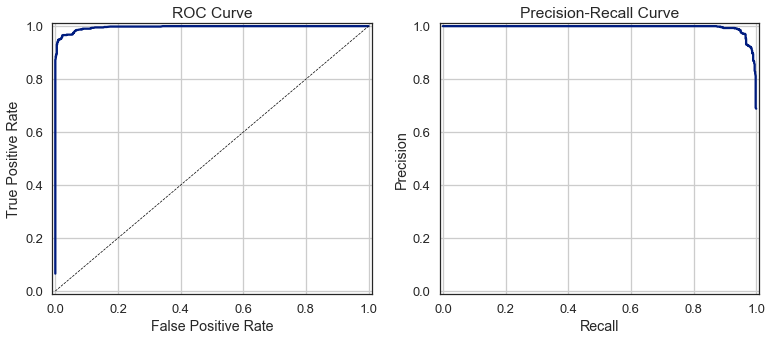

In [83]:
# Plot the ROC-AUC curbe 
fig, axList = plt.subplots(ncols = 2) 
fig.set_size_inches(11,5)
ax = axList[0]

fpr, tpr, thresholds = roc_curve(y_test_res, y_prob_res[:,1])
ax.plot(fpr, tpr)

# Random guess line 
ax.plot([0,1], [0,1], ls = '--', color = 'black', lw = 0.7)
ax.set(xlabel = 'False Positive Rate', ylabel = 'True Positive Rate', 
       xlim = [-0.01, 1.01], ylim = [-0.01, 1.01], 
       title = 'ROC Curve')
ax.grid(True)

# Plot the precision-recall curve 
ax = axList[1]

precision, recall, _ = precision_recall_curve(y_test_res, y_prob_res[:,1])
ax.plot(recall, precision)
ax.set(xlabel = 'Recall', ylabel = 'Precision', 
       xlim = [-0.01, 1.01], ylim = [-0.01, 1.01], 
       title = 'Precision-Recall Curve')

ax.grid(True)
plt.tight_layout()

In [84]:
feature_imp_res = pd.Series(model.feature_importances_, 
                            index = feature_cols).sort_values(ascending = False)

feature_imp_res

number_customer_service_calls    0.163902
total_day_charge                 0.161249
total_day_minutes                0.157338
intl_plan                        0.138752
total_eve_minutes                0.054469
total_eve_charge                 0.051790
voice_mail_plan                  0.035645
total_intl_calls                 0.031197
total_night_minutes              0.028880
total_night_charge               0.028494
number_vmail_messages            0.026930
total_intl_minutes               0.022596
total_intl_charge                0.022269
account_length                   0.020758
total_night_calls                0.019084
total_day_calls                  0.019050
total_eve_calls                  0.017596
dtype: float64

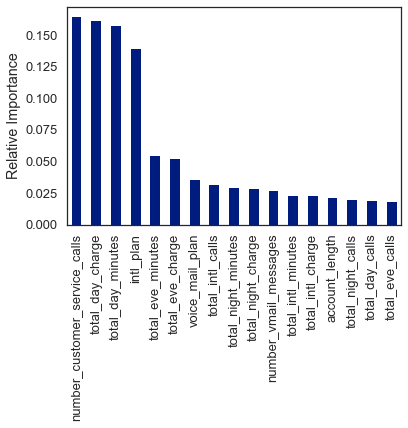

In [86]:
ax = feature_imp_res.plot(kind = 'bar')
ax.set(ylabel = 'Relative Importance'); 

Number of customer service calls is now the biggest predictor of customer churn, with daily cost being next importance.